In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import os
import re

import numpy as np
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from scipy import stats
from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot

import jieba

import gc

import seaborn as sns

In [2]:
xgb.__version__

'0.81'

In [3]:
!ls ../data/input

ad_drama_20180701_20180831.csv  drama_onair_vc.csv
drama_data.tsv


In [4]:
drama_df = pd.read_csv('../data/input/drama_data.tsv', sep='\t')
drama_onair_vc_df = pd.read_csv('../data/input/drama_onair_vc.csv', sep=',')

In [5]:
# 確認資料筆數
print(drama_df.shape)
print(drama_onair_vc_df.shape)

(5571, 10)
(52, 5)


In [6]:
#source dramas3
drama_df.head()

drama_id drama_name                                       introduction  \
0        28     我的自由年代  本劇劇情以90年代校園生活為故事背景，主要取景地為國立中央大學與國立宜蘭大學。 青春是什麼樣...   
1        28     我的自由年代  本劇劇情以90年代校園生活為故事背景，主要取景地為國立中央大學與國立宜蘭大學。 青春是什麼樣...   
2        28     我的自由年代  本劇劇情以90年代校園生活為故事背景，主要取景地為國立中央大學與國立宜蘭大學。 青春是什麼樣...   
3        28     我的自由年代  本劇劇情以90年代校園生活為故事背景，主要取景地為國立中央大學與國立宜蘭大學。 青春是什麼樣...   
4        87    下一站，幸福   女主角慕橙天性善良透明，是這個世上再也找不出第二個的國寶級的純情派，她不常掉淚，她水晶般的眼...   

   current_eps  views  weekly_views  actor_id actor_name  created_at  \
0           26   1968          1841      2404        是元介  2016-06-14   
1           26   1968          1841      2405        翁滋蔓  2016-06-14   
2           26   1968          1841      2967        任容萱  2016-06-14   
3           26   1968          1841      4489        李國毅  2016-06-14   
4           21     20           693      2785        許瑋甯  2016-06-14   

   updated_at  
0  2018-12-03  
1  2018-12-03  
2  2018-12-03  
3  2018-12-03  
4  2018-03-13

In [7]:
#source label vc
drama_onair_vc_df.head()

drama_id  onair_year  onair_month  total_vc  dst_cnt_ad_id
0     10045        2018            9    277028          18362
1     10052        2018           10    897098          49658
2     10058        2018           11    795614          44698
3     10070        2018           10    289997          17842
4     10081        2018           11    982678          75935

In [8]:
def prepare_training_data(drama_df, drama_vc):
    drama_df['actor'] = 1
    drama_info = pd.pivot_table(drama_df, 
                                index=['drama_id', 'drama_name', 'introduction', 'current_eps'], 
                                columns='actor_name', 
                                values='actor').fillna(0).reset_index()
    print()
    
    result = pd.merge(drama_info, drama_vc, on='drama_id')
    
    return result
    

In [9]:
total_df = prepare_training_data(drama_df, drama_onair_vc_df[['drama_id','total_vc']])

In [10]:
total_df.head()

drama_id  drama_name                                       introduction  \
0      9008  知否知否應是綠肥紅瘦  《知否知否應是綠肥紅瘦》故事講述一個北宋官宦家庭出生的少女 - 盛明蘭，她的人生故事和一個家...   
1      9378       孤芳不自賞  晉、燕、涼、秦四國征戰不休，晉國鎮北王楚北捷勇善戰、武功謀略過人。晉燕交戰之際，侍女白娉婷與...   
2      9407      今生是第一次  此劇講述羨慕有一個家的流浪女子尹志浩與房奴男子南世熙，陰錯陽差得成為住在同一屋簷下的房客房東...   
3      9408       Voice  本劇講述因一次事故而失去家人的刑警與112舉報中心隊員，在犯罪率第一、檢舉率全國最低的盛雲支...   
4      9413        戀愛先生  《戀愛先生》是由陝文投藝達公司出品，姚曉峰執導，靳東、江疏影領銜主演的都市愛情劇。該劇講述了...   

   current_eps    /  17直播  AHMET SARAÇOĞLU  AKIRA  ASTRO  \
0           73  0.0   0.0              0.0    0.0    0.0   
1           62  0.0   0.0              0.0    0.0    0.0   
2           16  0.0   0.0              0.0    0.0    0.0   
3           16  0.0   0.0              0.0    0.0    0.0   
4           45  0.0   0.0              0.0    0.0    0.0   

   Aim Satida Pinsinchai    ...     龍劭華  龍星涼  龐瀚辰   龐馳   龔俊   龔潔  龔麗君  龜梨和也  \
0                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
1                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
2                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
3                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
4                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   

   沈恩敬  total_vc  
0  0.0   3563845  
1  0.0    485908  
2  0.0    492516  
3  0.0    312939  
4  0.0    693094  

[5 rows x 3551 columns]

In [11]:
def split_dataset_by_drama_name(df, list_of_drama):
    test_df = df[df.drama_name.isin(list_of_drama)]
    train_df = df.drop(df[df.drama_name.isin(list_of_drama)].index)
    return train_df, test_df

In [12]:
test_drama = ['知否知否應是綠肥紅瘦', '喜歡你時風好甜', '最佳的炸雞', '你有念大學嗎？', '必勝大丈夫']
train_df, test_df = split_dataset_by_drama_name(total_df, test_drama)

In [13]:
test_df.total_vc

0     3563845
48    2532870
49    2292824
50     565613
51     479627
Name: total_vc, dtype: int64

In [14]:
test_df.head()

drama_id  drama_name                                       introduction  \
0       9008  知否知否應是綠肥紅瘦  《知否知否應是綠肥紅瘦》故事講述一個北宋官宦家庭出生的少女 - 盛明蘭，她的人生故事和一個家...   
48     10190     你有念大學嗎？  由安心亞、禾浩辰、邵翔、吳品潔、邱宇辰領銜主演。距離大學指考倒數一百天，學霸常可艾（安心亞飾...   
49     10191       必勝大丈夫  由蔡振南、周曉涵、周孝安、林昀希、邱昊奇、陳天仁領銜主演。架構改編自韓劇《月桂樹西裝店的紳士...   
50     10200     喜歡你時風好甜  故事主要講述雙雙在離家出走追求夢想時，遇見了一個才華橫溢卻冷漠敏感的男人齊勳。齊勳由於兒時的...   
51     10203       最佳的炸雞  《致忘了詩的你》新生代演員 朴宣浩、《PRODUCE 101》金素慧、《心動警報》188長腿...   

    current_eps    /  17直播  AHMET SARAÇOĞLU  AKIRA  ASTRO  \
0            73  0.0   0.0              0.0    0.0    0.0   
48           17  0.0   0.0              0.0    0.0    0.0   
49           41  0.0   0.0              0.0    0.0    0.0   
50           24  0.0   0.0              0.0    0.0    0.0   
51           12  0.0   0.0              0.0    0.0    0.0   

    Aim Satida Pinsinchai    ...     龍劭華  龍星涼  龐瀚辰   龐馳   龔俊   龔潔  龔麗君  龜梨和也  \
0                     0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
48                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
49                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
50                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
51                    0.0    ...     0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   

    沈恩敬  total_vc  
0   0.0   3563845  
48  0.0   2532870  
49  0.0   2292824  
50  0.0    565613  
51  0.0    479627  

[5 rows x 3551 columns]

In [15]:
train_df.shape

(47, 3551)

# 觀察 target 分佈

In [78]:
total_vc = train_df.total_vc
total_vc.describe()

count    4.700000e+01
mean     1.009641e+06
std      9.415677e+05
min      2.201740e+05
25%      4.639705e+05
50%      7.269230e+05
75%      1.002448e+06
max      4.525217e+06
Name: total_vc, dtype: float64

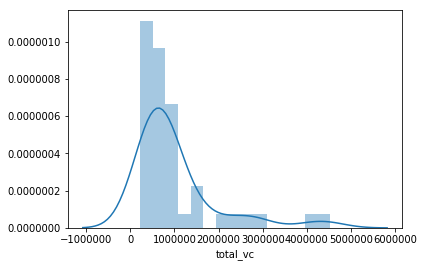

In [79]:
sns.distplot(total_vc)

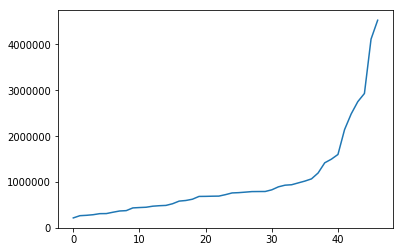

In [80]:
sns.lineplot(data=total_vc.sort_values().reset_index(drop=True))

In [67]:
total_vc_log = np.log(train_df.total_vc).sort_values(ascending=False)
total_vc_log.describe()

count    47.000000
mean     13.539753
std       0.715636
min      12.302173
25%      13.047278
50%      13.496576
75%      13.817762
max      15.325176
Name: total_vc, dtype: float64

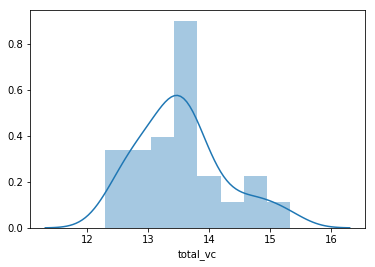

In [70]:
sns.distplot(total_vc_log)

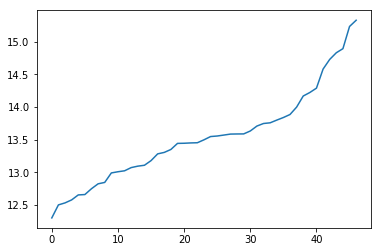

In [73]:
sns.lineplot(data=total_vc_log.sort_values().reset_index(drop=True))

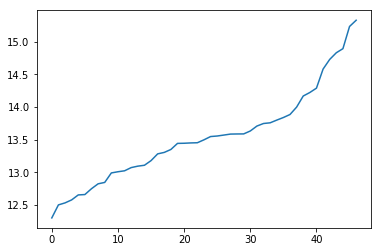

In [241]:
sns.lineplot(data=np.log(train_df.total_vc).sort_values().reset_index(drop=True))

# 訓練 TIIDF plus 結巴分詞

In [16]:
def get_tokens(s):
    try:
        cleaned = re.sub("[\s+\.\!\/_,$%^*(+\"\')]+|[+——()?【】「」《》～“”！：:，。？、·＠＃＄％＾＆＊~@#￥%……&*（）]+",'',s)
        result = " ".join([i for i in jieba.cut_for_search(cleaned, HMM=True)])
        return result
    except Exception as e:
        print(e)
        print(s)
        

In [17]:
def get_clean(s):
    try:
        cleaned = re.sub("[\s+\.\!\/_,$%^*(+\"\')]+|[+——()?【】「」《》～“”！：:，。？、·＠＃＄％＾＆＊~@#￥%……&*（）]+",'',s)
        return cleaned
    except Exception as e:
        print(e)
        print(s)
        

In [18]:
def train_vectorizer(df, col, clean_method, tfidf_vectorizer):
    if len(df[df[col].isnull()]) > 0:
        raise
    df['tokens'] = df[col].apply(lambda x: clean_method(x))
    
    try:
        tfidf_vectorizer.fit(df['tokens'])
        return tfidf_vectorizer
    except ValueError as e:
        print(e)
        print('nothing can parse')
        
    

In [141]:
intro_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1),
    norm='l2',
    #max_df=0.3,
    min_df=3,
    smooth_idf=True,
    max_features=50000)

intro_vectorizer = train_vectorizer(total_df, 'introduction', get_tokens, intro_vectorizer)

In [142]:
len(intro_vectorizer.get_feature_names())

89

In [143]:
intro_vectorizer.get_feature_names()

['11',
 '12',
 '2017',
 '2018',
 'mbc',
 '一位',
 '一個',
 '一家',
 '一次',
 '一起',
 '不同',
 '中國',
 '主演',
 '之間',
 '互相',
 '人們',
 '人生',
 '他們',
 '但是',
 '作品',
 '作家',
 '偶像',
 '兩人',
 '兩個',
 '公司',
 '共同',
 '出品',
 '刑警',
 '劇情',
 '劇由',
 '劇該',
 '古裝',
 '合作',
 '同名',
 '同時',
 '喜劇',
 '困境',
 '執導',
 '女性',
 '尋找',
 '導演',
 '小說',
 '少女',
 '工作',
 '幫助',
 '情感',
 '意外',
 '愛情',
 '愛的',
 '戀愛',
 '成為',
 '成長',
 '打造',
 '播出',
 '改編',
 '故事',
 '日起',
 '晚上',
 '最終',
 '朋友',
 '本劇',
 '此劇',
 '溫暖',
 '火連續',
 '生活',
 '男人',
 '男女',
 '發生',
 '神秘',
 '第一',
 '經過',
 '網絡',
 '背景',
 '能力',
 '自己',
 '英語',
 '解決',
 '該劇',
 '講述',
 '追求',
 '遇到',
 '過程',
 '都市',
 '電視劇',
 '青春',
 '韓劇',
 '韓國',
 '韓語',
 '領銜']

## 處理 drame name (Depresed)

In [22]:
name_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    norm='l2',
    #max_df=1,
    #min_df=0,
    smooth_idf=True,
    max_features=30000)

name_vectorizer = train_vectorizer(total_df, 'drama_name', get_clean, intro_vectorizer)

After pruning, no terms remain. Try a lower min_df or a higher max_df.
nothing can parse


In [23]:
len(name_vectorizer.get_feature_names())

AttributeError: 'NoneType' object has no attribute 'get_feature_names'

In [116]:
name_vectorizer.get_feature_names()

['0之',
 '0之後',
 '0但',
 '0但仍',
 '0但仍1',
 '0但仍17',
 '0但仍17雖',
 '14',
 '141',
 '1415',
 '14159',
 '15',
 '159',
 '17',
 '17雖',
 '17雖然',
 '17雖然3',
 '17雖然30',
 '20',
 '20之',
 '20之後',
 '30',
 '30但',
 '30但仍',
 '30但仍1',
 '30但仍17',
 '31',
 '314',
 '3141',
 '31415',
 '314159',
 '41',
 '415',
 '4159',
 '59',
 '7雖',
 '7雖然',
 '7雖然3',
 '7雖然30',
 '7雖然30但',
 'ab',
 'abo',
 'abou',
 'about',
 'aboutt',
 'bo',
 'bou',
 'bout',
 'boutt',
 'boutti',
 'ce',
 'co',
 'cop',
 'cops',
 'cops我',
 'cops我的',
 'el',
 'elo',
 'ic',
 'ice',
 'im',
 'ime',
 'is',
 'ist',
 'isty',
 'isty謎',
 'isty謎霧',
 'lo',
 'me',
 'mel',
 'melo',
 'mi',
 'mis',
 'mist',
 'misty',
 'misty謎',
 'oc',
 'oco',
 'ocop',
 'ocops',
 'ocops我',
 'oi',
 'oic',
 'oice',
 'op',
 'ops',
 'ops我',
 'ops我的',
 'ops我的鬼',
 'ou',
 'out',
 'outt',
 'outti',
 'outtim',
 'ps',
 'ps我',
 'ps我的',
 'ps我的鬼',
 'ps我的鬼神',
 'st',
 'sty',
 'sty謎',
 'sty謎霧',
 's我',
 's我的',
 's我的鬼',
 's我的鬼神',
 's我的鬼神搭',
 'ti',
 'tim',
 'time',
 'tt',
 'tti',
 'ttim',
 'ttime',
 'tw',


## 將訓練資料切詞，將結果套到 train_df 上

In [82]:
def get_intro_features(df, vectorizers):
    df['tokens'] = df['introduction'].apply(lambda x: get_tokens(x))
    intro_features = vectorizers.transform(df['tokens'])
    print('intro features shape: {}'.format(intro_features.shape))
    return intro_features, vectorizers.get_feature_names()

In [180]:
train_intro_features = get_intro_features(train_df, intro_vectorizer)

In [356]:
# check
pd.DataFrame(train_df.total_vc.values)

0
0    485908
1    492516
2    312939
3    693094
4    695088
5    314722
6    726923
7    794901
8    781654
9    586257
10   268664
11  4113748
12  1022219
13  1070448
14   475305
15   446057
16   452636
17   627177
18   932974
19   764162
20   220174
21  4525217
22   378900
23   688183
24   438063
25   832014
26   528734
27   770442
28   689666
29   793431
30  1498878
31  2752281
32  1420125
33   942732
34  2485551
35  1198518
36   277028
37   897098
38   795614
39   289997
40   982678
41  1601936
42   344149
43   370879
44   599581
45  2930020
46  2143857

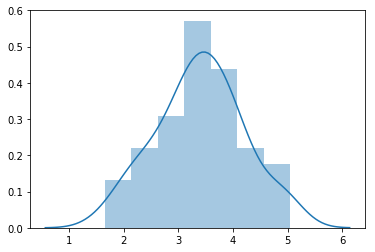

In [188]:
## viz

sns.distplot(train_intro_features.sum(axis=1))

In [279]:
train_df.total_vc.values.shape

(47,)

In [289]:
token_vc_df = \
    pd.DataFrame({'tokens':pd.DataFrame(train_intro_features.sum(axis=1)).values.reshape(47,), 
                  'total_vc':train_df.total_vc.values.reshape(47,)})

In [296]:
token_vc_df.head()

tokens  total_vc
0  1.985073    485908
1  2.159337    492516
2  3.827527    312939
3  4.893477    693094
4  4.835655    695088

In [298]:
token_vc_df['total_log_vc'] = token_vc_df.apply(lambda row: np.log(row.total_vc), axis=1)

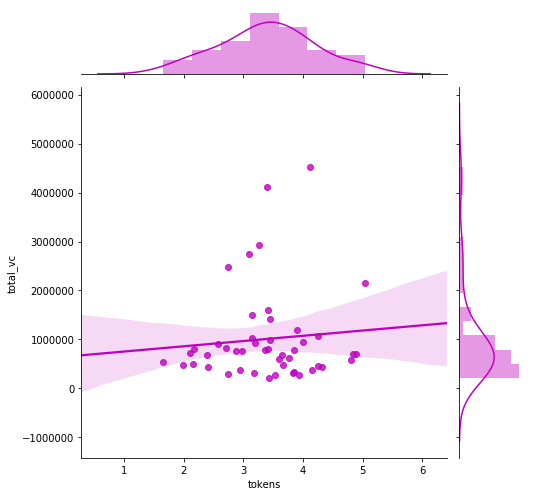

In [299]:
g = sns.jointplot("tokens", "total_vc", data=token_vc_df, kind="reg",
                   color="m", height=7)

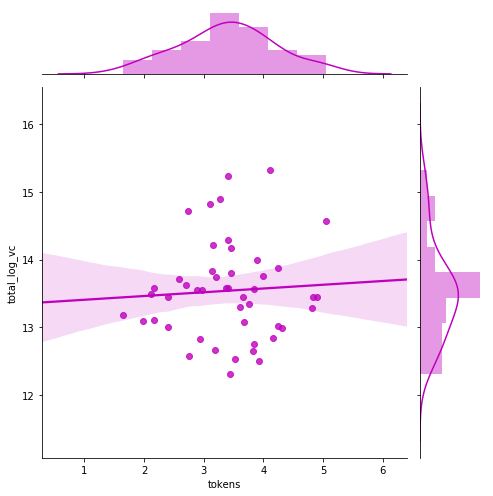

In [300]:
g = sns.jointplot("tokens", "total_log_vc", data=token_vc_df, kind="reg",
                   color="m", height=7)

## 演員名單的 CSR matrix

In [84]:
def get_actor_features(df, drop_cols):
    actor_df = df.drop(drop_cols, axis=1)
    actor_features = csr_matrix(actor_df.values)
    print('actors shape: {}'.format(actor_features.shape))
    return actor_features, actor_df.columns

In [321]:
train_actor_features = get_actor_features(train_df, 
    ['drama_id','drama_name','introduction', '/','total_vc','tokens','name_cleaned','current_eps'])

shape: (47, 3545)


## 其他 matrix

In [91]:
def get_other_features(df):
    other_df = df[['current_eps']]
    other_df['len_intro'] = train_df.apply(lambda row: len(row.introduction), axis=1)
    other_df['len_name'] = train_df.apply(lambda row: len(row.drama_name), axis=1)
    
    actor_features, actor_names = get_actor_features(df, 
        ['drama_id','drama_name','introduction', '/','total_vc','tokens','current_eps'])
    other_df['len_actors'] = actor_features.sum(axis=1)
    
    other_features = csr_matrix(other_df.values)
    print('other features shape: {}'.format(other_features.shape))
    return other_features, other_df.columns
    

In [329]:
train_other_features = get_other_features(train_df)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


shape: (47, 4)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## 組合所有feature

In [144]:
def get_features_target(df, log_target=True, is_train=True):
    
    intro_features, token_names = get_intro_features(df, intro_vectorizer)
    actor_features, actor_names = get_actor_features(df, 
        ['drama_id','drama_name','introduction', '/','total_vc','tokens','current_eps'])
    other_features, other_names = get_other_features(df)
    total_features = hstack([intro_features, actor_features, other_features])
    
    # create feature name list
    features_name = []
    #features_name.extend(name_vectorizer.get_feature_names())
    features_name.extend(token_names)
    features_name.extend(actor_names)
    features_name.extend(other_names)

    
    if is_train:
        print('Features of training data')
        train_target = df['total_vc']
        if log_target:
            train_target_log = np.log(train_target)
            return total_features, train_target, train_target_log, features_name
        else:
            return total_features, train_target, features_name
    else:
        print('Features of testing data')
        return total_features

In [145]:
train_df.shape

(47, 3552)

In [146]:
train_features, train_target, train_target_log, features_name = get_features_target(train_df, log_target=True, is_train=True)

intro features shape: (47, 89)
actors shape: (47, 3545)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


actors shape: (47, 3545)
other features shape: (47, 4)
Features of training data


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Save data

In [2256]:
train_features_df = pd.DataFrame(train_features.todense())
train_target_df = pd.DataFrame(train_target)
train_features_df.to_csv('../data/output/train_features_df.csv', index=False)
train_target_df.to_csv('../data/output/train_target_df.csv', index=False)

In [2259]:
train_target_df.head()

total_vc
1    485908
2    492516
3    312939
4    693094
5    695088

## 準備 Testing Data

In [147]:
#Prepare data

test_features = get_features_target(test_df, log_target=True, is_train=False)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


intro features shape: (5, 89)
actors shape: (5, 3545)
actors shape: (5, 3545)
other features shape: (5, 4)
Features of testing data


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [148]:

d_test = xgb.DMatrix(test_features)

In [149]:
## check features

d_test.num_col() == train_features.shape[1]

True

In [2258]:
# Save Data
test_features_df = pd.DataFrame(test_features.todense())
test_features_df.to_csv('../data/output/test_features_df.csv', index=False)

## traning model

In [316]:
print("Modeling")
cv_scores = []
xgb_preds = []


    # Split out a validation set
X_train, X_valid, y_train, y_valid = train_test_split(
        train_features, train_target, test_size=0.2, random_state=23)


d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)

Modeling


In [317]:
best_xgb_params = {'eta': 0.02, 
              'max_depth': 2,
              'booster': 'gbtree',
              'n_estimators': 2000,
              #'gamma': 0.5,
              #'lambda': 5,
              'alpha': 1,
              'subsample': 0.8, 
              'colsample_bytree': 0.3, 
              'objective': 'reg:linear', 
              'min_child_weight': 5, 
              'eval_metric': 'rmse', 
              'seed': 23,
              'n_jobs': 4,
              #'feature_selector': 'shuffle'
             }

In [ ]:
xgb_params = {'eta': 0.02, 
              'max_depth': 2,
              'booster': 'gbtree',
              'n_estimators': 2000,
              #'gamma': 0.5,
              #'lambda': 5,
              #'alpha': 1,
              'subsample': 0.8, 
              'colsample_bytree': 0.3, 
              'objective': 'reg:linear', 
              'min_child_weight': 5, 
              'eval_metric': 'rmse', 
              'seed': 23,
              'n_jobs': 4,
              #'feature_selector': 'shuffle'
             }

watchlist = [(d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 2000, watchlist, verbose_eval=True, early_stopping_rounds=200)



[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	valid-rmse:1.49855e+06
Will train until valid-rmse hasn't improved in 200 rounds.
[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	valid-rmse:1.48269e+06
[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	valid-rmse:1.46974e+06
[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[3]	valid-rmse:1.45264e+06
[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[4]	valid-rmse:1.43905e+06
[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[5]	valid-rmse:1.4279e+06
[11:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[6]

[11:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[59]	valid-rmse:1.06151e+06
[11:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[60]	valid-rmse:1.05755e+06
[11:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[61]	valid-rmse:1.05212e+06
[11:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[62]	valid-rmse:1.04894e+06
[11:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[63]	valid-rmse:1.04563e+06
[11:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[64]	valid-rmse:1.04291e+06
[11:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[65]	valid-rmse:1.04062e+06
[11:15:38] src/tree/updater

[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[120]	valid-rmse:948392
[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[121]	valid-rmse:949581
[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[122]	valid-rmse:948352
[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[123]	valid-rmse:948844
[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[124]	valid-rmse:943618
[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[125]	valid-rmse:942598
[11:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[126]	valid-rmse:943324
[11:15:39] src/tree/updater_prune.cc:74: tree pruning e

[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[181]	valid-rmse:905682
[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[182]	valid-rmse:906514
[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[183]	valid-rmse:906798
[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[184]	valid-rmse:905539
[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[185]	valid-rmse:905952
[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[186]	valid-rmse:906007
[11:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[187]	valid-rmse:906130
[11:15:40] src/tree/updater_prune.cc:74: tree pruning e

[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[242]	valid-rmse:892100
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[243]	valid-rmse:892295
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[244]	valid-rmse:893520
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[245]	valid-rmse:892898
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[246]	valid-rmse:893753
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[247]	valid-rmse:892173
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[248]	valid-rmse:890627
[11:15:41] src/tree/updater_prune.cc:74: tree pruning e

[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[303]	valid-rmse:875705
[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[304]	valid-rmse:875096
[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[305]	valid-rmse:874347
[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[306]	valid-rmse:873541
[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[307]	valid-rmse:872215
[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[308]	valid-rmse:871721
[11:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[309]	valid-rmse:871645
[11:15:42] src/tree/updater_prune.cc:74: tree pruning e

[363]	valid-rmse:852884
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[364]	valid-rmse:852981
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[365]	valid-rmse:852892
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[366]	valid-rmse:851324
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[367]	valid-rmse:851817
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[368]	valid-rmse:852321
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[369]	valid-rmse:851389
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[370]	valid-rmse:850993
[11:15:43] src/tree/updater_pru

[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[425]	valid-rmse:831527
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	valid-rmse:830539
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[427]	valid-rmse:829652
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[428]	valid-rmse:830130
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[429]	valid-rmse:829789
[11:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[430]	valid-rmse:827304
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[431]	valid-rmse:827001
[11:15:44] src/tree/updater_prune.cc:74: tree pruning e

[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[486]	valid-rmse:797794
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[487]	valid-rmse:797058
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[488]	valid-rmse:796745
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[489]	valid-rmse:796509
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[490]	valid-rmse:793635
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[491]	valid-rmse:791635
[11:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[492]	valid-rmse:791919
[11:15:44] src/tree/updater_prune.cc:74: tree pruning e

[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[547]	valid-rmse:772053
[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[548]	valid-rmse:771532
[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[549]	valid-rmse:770008
[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[550]	valid-rmse:767398
[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[551]	valid-rmse:767198
[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[552]	valid-rmse:768702
[11:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[553]	valid-rmse:768286
[11:15:45] src/tree/updater_prune.cc:74: tree pruning e

[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[608]	valid-rmse:758399
[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[609]	valid-rmse:758149
[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[610]	valid-rmse:758297
[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[611]	valid-rmse:757872
[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[612]	valid-rmse:757526
[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[613]	valid-rmse:757789
[11:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[614]	valid-rmse:757330
[11:15:46] src/tree/updater_prune.cc:74: tree pruning e

[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[668]	valid-rmse:741973
[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[669]	valid-rmse:740908
[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[670]	valid-rmse:741811
[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[671]	valid-rmse:739792
[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[672]	valid-rmse:739832
[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[673]	valid-rmse:739536
[11:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[674]	valid-rmse:739867
[11:15:47] src/tree/updater_prune.cc:74: tree pruning e

[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[729]	valid-rmse:728263
[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[730]	valid-rmse:726817
[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[731]	valid-rmse:725614
[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[732]	valid-rmse:724362
[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[733]	valid-rmse:724989
[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[734]	valid-rmse:724341
[11:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[735]	valid-rmse:724138
[11:15:48] src/tree/updater_prune.cc:74: tree pruning e

[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[789]	valid-rmse:712894
[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[790]	valid-rmse:712277
[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[791]	valid-rmse:710041
[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[792]	valid-rmse:709509
[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[793]	valid-rmse:707735
[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[794]	valid-rmse:708150
[11:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[795]	valid-rmse:707091
[11:15:49] src/tree/updater_prune.cc:74: tree pruning e

[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[850]	valid-rmse:702004
[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[851]	valid-rmse:702073
[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[852]	valid-rmse:702095
[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[853]	valid-rmse:702647
[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[854]	valid-rmse:701985
[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[855]	valid-rmse:701934
[11:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[856]	valid-rmse:702023
[11:15:50] src/tree/updater_prune.cc:74: tree pruning e

[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[911]	valid-rmse:690777
[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[912]	valid-rmse:690776
[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[913]	valid-rmse:690920
[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[914]	valid-rmse:689434
[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[915]	valid-rmse:688217
[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[916]	valid-rmse:687743
[11:15:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[917]	valid-rmse:688092
[11:15:51] src/tree/updater_prune.cc:74: tree pruning e

[971]	valid-rmse:678267
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[972]	valid-rmse:678640
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[973]	valid-rmse:677579
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[974]	valid-rmse:677271
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[975]	valid-rmse:677126
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[976]	valid-rmse:676710
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[977]	valid-rmse:676266
[11:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[978]	valid-rmse:675957
[11:15:52] src/tree/updater_pru

[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1033]	valid-rmse:669342
[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1034]	valid-rmse:669068
[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1035]	valid-rmse:668982
[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1036]	valid-rmse:669192
[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1037]	valid-rmse:669542
[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1038]	valid-rmse:669092
[11:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1039]	valid-rmse:668345
[11:15:53] src/tree/updater_prune.cc:74: tree pr

[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1094]	valid-rmse:657862
[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1095]	valid-rmse:656810
[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1096]	valid-rmse:655980
[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1097]	valid-rmse:656221
[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1098]	valid-rmse:656096
[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1099]	valid-rmse:656387
[11:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1100]	valid-rmse:655857
[11:15:54] src/tree/updater_prune.cc:74: tree pr

[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1154]	valid-rmse:655609
[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1155]	valid-rmse:655766
[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1156]	valid-rmse:654620
[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1157]	valid-rmse:653859
[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1158]	valid-rmse:653666
[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1159]	valid-rmse:653723
[11:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1160]	valid-rmse:653560
[11:15:55] src/tree/updater_prune.cc:74: tree pr

[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1215]	valid-rmse:645379
[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1216]	valid-rmse:645985
[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1217]	valid-rmse:646030
[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1218]	valid-rmse:646088
[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[1219]	valid-rmse:646067
[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1220]	valid-rmse:647099
[11:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1221]	valid-rmse:646942
[11:15:56] src/tree/updater_prune.cc:74: tree pr

[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1276]	valid-rmse:638880
[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1277]	valid-rmse:638809
[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1278]	valid-rmse:638411
[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1279]	valid-rmse:638376
[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1280]	valid-rmse:638620
[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1281]	valid-rmse:638261
[11:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1282]	valid-rmse:638191
[11:15:57] src/tree/updater_prune.cc:74: tree pr

[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1337]	valid-rmse:634835
[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1338]	valid-rmse:635192
[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1339]	valid-rmse:635402
[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1340]	valid-rmse:635287
[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1341]	valid-rmse:635137
[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1342]	valid-rmse:634914
[11:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1343]	valid-rmse:635410
[11:15:58] src/tree/updater_prune.cc:74: tree pr

[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1398]	valid-rmse:632057
[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1399]	valid-rmse:632074
[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1400]	valid-rmse:632010
[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1401]	valid-rmse:631854
[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1402]	valid-rmse:631960
[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1403]	valid-rmse:631882
[11:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1404]	valid-rmse:631799
[11:15:59] src/tree/updater_prune.cc:74: tree pr

[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1459]	valid-rmse:623318
[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1460]	valid-rmse:623024
[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1461]	valid-rmse:623586
[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1462]	valid-rmse:622863
[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1463]	valid-rmse:622794
[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1464]	valid-rmse:622526
[11:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1465]	valid-rmse:622666
[11:16:00] src/tree/updater_prune.cc:74: tree pr

[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1520]	valid-rmse:619416
[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1521]	valid-rmse:619282
[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1522]	valid-rmse:618895
[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1523]	valid-rmse:619054
[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1524]	valid-rmse:618231
[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1525]	valid-rmse:617535
[11:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1526]	valid-rmse:617240
[11:16:01] src/tree/updater_prune.cc:74: tree pr

[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1581]	valid-rmse:608779
[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1582]	valid-rmse:608491
[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1583]	valid-rmse:608216
[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1584]	valid-rmse:607603
[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1585]	valid-rmse:607682
[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1586]	valid-rmse:607433
[11:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1587]	valid-rmse:607785
[11:16:02] src/tree/updater_prune.cc:74: tree pr

[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1642]	valid-rmse:605544
[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1643]	valid-rmse:605436
[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1644]	valid-rmse:605360
[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1645]	valid-rmse:605133
[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1646]	valid-rmse:604519
[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1647]	valid-rmse:604269
[11:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1648]	valid-rmse:603849
[11:16:03] src/tree/updater_prune.cc:74: tree pr

[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1703]	valid-rmse:601123
[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1704]	valid-rmse:601959
[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1705]	valid-rmse:602169
[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1706]	valid-rmse:602383
[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1707]	valid-rmse:602476
[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1708]	valid-rmse:602278
[11:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1709]	valid-rmse:602338
[11:16:04] src/tree/updater_prune.cc:74: tree pr

[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1764]	valid-rmse:599840
[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1765]	valid-rmse:599911
[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1766]	valid-rmse:599613
[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1767]	valid-rmse:599503
[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1768]	valid-rmse:599612
[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1769]	valid-rmse:599794
[11:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1770]	valid-rmse:600003
[11:16:05] src/tree/updater_prune.cc:74: tree pr

In [ ]:
print(model.attributes()['best_msg'])
cv_scores.append(float(model.attributes()['best_score']))
print(cv_scores)
gc.collect()

## Check distribution of valid data

In [ ]:
X = np.arange(0.0, 1.0, 0.1, dtype='float32').reshape(-1,1)
valid = xgb.DMatrix(X_valid)
predictions = model.predict(valid)

In [ ]:
valid = pd.DataFrame({"expect": y_valid,"pred": predictions}).sort_values(by=['expect'])

In [ ]:
valid

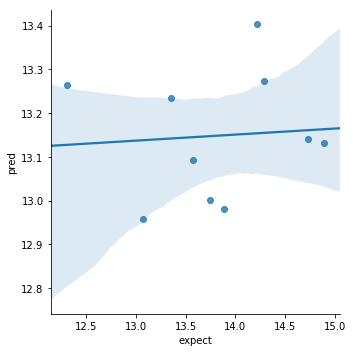

In [314]:
sns.lmplot(data=valid, x='expect', y='pred')

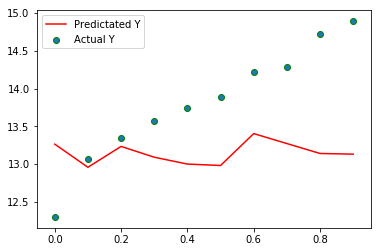

In [315]:
plt.scatter(X, valid.expect, edgecolors='g')
plt.plot(X, valid.pred,'r')
plt.legend([ 'Predictated Y' ,'Actual Y'])
plt.show()

## Feature Importance

In [298]:
len(features_name)

3638

In [299]:
def get_feature_importance(model, features_name):
    feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index', columns=['fscore'])
    feature_importance.index = feature_importance.index.set_names('col_id')
    feature_importance = feature_importance.reset_index()
    feature_importance['col_name'] = feature_importance.apply(
        lambda row: features_name[int(row.col_id.replace('f', ''))] , axis=1)
    feature_importance = feature_importance.sort_values(by=['fscore'], ascending=False)
    return feature_importance

In [300]:
feature_importance = get_feature_importance(model, features_name)

In [301]:
feature_importance

col_id  fscore     col_name
9   f3635     982    len_intro
10    f78     771           講述
0     f55     748           故事
2   f3634     635  current_eps
5     f12     485           主演
13  f3637     422   len_actors
3   f3636     356     len_name
12    f54     235           改編
8     f61     192           此劇
7     f88     191           領銜
4     f37     161           執導
1     f86     101           韓國
20    f75      79           英語
16    f77      63           該劇
18    f43      49           工作
14     f6      46           一個
6     f52      34           打造
11    f20      32           作家
17    f74      20           自己
23    f87      19           韓語
15    f53      12           播出
19    f83       9          電視劇
21    f29       9           劇由
22    f33       5           同名

In [302]:
#del X_train, X_valid, y_train, y_valid

## Predict

In [303]:
test_expect = test_df['total_vc'].reset_index(drop=True)

In [304]:
test_expect_v2 = np.array([1171476, 509014, 493562, 337668, 258536])

In [305]:
test_predict = model.predict(d_test)

In [306]:
def compare(test_df, expect1, expect2, d_test, model, target='vc'):
    
    raw_predict = model.predict(d_test)
    if target == 'vc':
        test_predict = raw_predict
    elif target == 'log_vc':
        test_predict = np.e ** raw_predict
    
    
    
    result = pd.DataFrame(data={'drama_id':  test_df.drama_id.reset_index(drop=True), 
                   'drama_name': test_df.drama_name.reset_index(drop=True),
                   'total_vc':expect1, 
                   'total_vc_v2': expect2, 
                   'predict': np.round(test_predict),
                   'mean' : np.mean(expect2),
                   'diff_vc_%': np.round((1 - (expect1 / test_predict.T)) * 100, 2),
                   'diff_vc_v2_%': np.round((1 - (expect2 / test_predict.T)) * 100, 2),
                   'diff_vc_basline_%': np.round((1 - (expect2 / np.mean(expect2))) * 100, 2)
                               })
    
    return result

In [307]:
result_df = compare(test_df, test_expect, test_expect_v2, d_test, model, target='log_vc')

In [308]:
result_df

drama_id  drama_name  total_vc  total_vc_v2   predict      mean  diff_vc_%  \
0      9008  知否知否應是綠肥紅瘦   3563845      1171476  560381.0  554051.2    -535.97   
1     10190     你有念大學嗎？   2532870       509014  824421.0  554051.2    -207.23   
2     10191       必勝大丈夫   2292824       493562  517252.0  554051.2    -343.27   
3     10200     喜歡你時風好甜    565613       337668  652594.0  554051.2      13.33   
4     10203       最佳的炸雞    479627       258536  882352.0  554051.2      45.64   

   diff_vc_v2_%  diff_vc_basline_%  
0       -109.05            -111.44  
1         38.26               8.13  
2          4.58              10.92  
3         48.26              39.05  
4         70.70              53.34

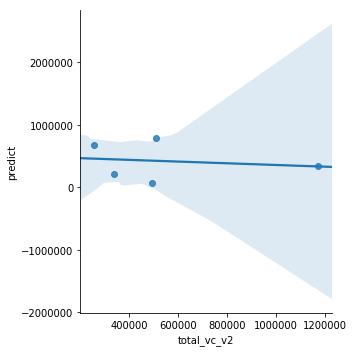

In [259]:
sns.lmplot(data=result_df, x="total_vc_v2", y="predict")

## Feature Importance

In [76]:
features_name = []
features_name.extend(name_vectorizer.get_feature_names())
features_name.extend(intro_vectorizer.get_feature_names())
features_name.extend(drama_actor.columns)
features_name.extend(train_other_df.columns)



NameError: name 'drama_actor' is not defined

In [2244]:
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index', columns=['fscore'])

In [2245]:
feature_importance.index = feature_importance.index.set_names('col_id')

In [2246]:
feature_importance = feature_importance.reset_index()

In [2247]:
feature_importance['col_name'] = feature_importance.apply(
    lambda row: features_name[int(row.col_id.replace('f', ''))] , axis=1)

In [2223]:
feature_importance = feature_importance.sort_values(by=['fscore'], ascending=False)

In [2224]:
feature_importance.head(100)

col_id  fscore     col_name
9   f11612     330    len_intro
3   f11611     239  current_eps
0    f6867     233           講述
1    f4115     197           故事
8   f11613     142     len_name
10  f11614     141   len_actors
5     f694     109           主演
12   f4086      59           改編
16   f3105      54           工作
2    f2285      47           執導
14   f4728      42           此劇
6    f7854      36           領銜
13   f6811      30           該劇
7    f7817      19           韓國
17   f6360       7           自己
18   f1002       7           作家
20   f1939       7           同名
15   f6453       6           英語
19   f3805       4           打造
21    f197       4           一個
11   f4036       3           播出
4    f7824       2           韓語
23   f1572       2           劇由
22   f7750       1          電視劇

In [642]:
train_features.col

array([ 2306,  2304,   763, ..., 31223, 32646, 32894], dtype=int32)

## GridSearch CV

### XGBRegressor

https://xgboost.readthedocs.io/en/latest/python/python_api.html

```
max_depth (int) – Maximum tree depth for base learners.
learning_rate (float) – Boosting learning rate (xgb’s “eta”)
n_estimators (int) – Number of trees to fit.
verbosity (int) – The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
silent (boolean) – Whether to print messages while running boosting. Deprecated. Use verbosity instead.
objective (string or callable) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
booster (string) – Specify which booster to use: gbtree, gblinear or dart.
nthread (int) – Number of parallel threads used to run xgboost. (Deprecated, please use n_jobs)
n_jobs (int) – Number of parallel threads used to run xgboost. (replaces nthread)
gamma (float) – Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight (int) – Minimum sum of instance weight(hessian) needed in a child.
max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.
subsample (float) – Subsample ratio of the training instance.
colsample_bytree (float) – Subsample ratio of columns when constructing each tree.
colsample_bylevel (float) – Subsample ratio of columns for each level.
colsample_bynode (float) – Subsample ratio of columns for each split.
reg_alpha (float (xgb's alpha)) – L1 regularization term on weights
reg_lambda (float (xgb's lambda)) – L2 regularization term on weights
scale_pos_weight (float) – Balancing of positive and negative weights.
base_score – The initial prediction score of all instances, global bias.
seed (int) – Random number seed. (Deprecated, please use random_state)
random_state (int) – Random number seed. (replaces seed)
missing (float, optional) – Value in the data which needs to be present as a missing value. If None, defaults to np.nan.
importance_type (string, default "gain") – The feature importance type for the feature_importances_ property: either “gain”, “weight”, “cover”, “total_gain” or “total_cover”.
**kwargs (dict, optional) –
Keyword arguments for XGBoost Booster object. Full documentation of parameters can be found here: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst. Attempting to set a parameter via the constructor args and **kwargs dict simultaneously will result in a TypeError.
                ```

In [1867]:
X_train, X_valid, y_train, y_valid = train_test_split(
        train_features, train_target, test_size=0.2, random_state=23)

xgb1 = XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [3, 10],
              'min_child_weight': [0, 1, 5],
              'subsample': [0.8],
              'colsample_bytree': [0.1, 0.5],
              'n_estimators': [1000],
              'random_state': [23],
              'booster': ['gbtree']}

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_valid, y_valid]]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(X_train, y_train, **fit_params)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[0]	validation_0-rmse:1.46199e+06
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.41428e+06
[2]	validation_0-rmse:1.3764e+06
[3]	validation_0-rmse:1.34062e+06
[4]	validation_0-rmse:1.30183e+06
[5]	validation_0-rmse:1.2735e+06
[6]	validation_0-rmse:1.25124e+06
[7]	validation_0-rmse:1.22539e+06


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   53.5s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[8]	validation_0-rmse:1.20744e+06
[9]	validation_0-rmse:1.19282e+06
[10]	validation_0-rmse:1.15462e+06
[11]	validation_0-rmse:1.14062e+06
[12]	validation_0-rmse:1.13163e+06
[13]	validation_0-rmse:1.1225e+06
[14]	validation_0-rmse:1.11497e+06
[15]	validation_0-rmse:1.10773e+06
[16]	validation_0-rmse:1.1036e+06
[17]	validation_0-rmse:1.09635e+06
[18]	validation_0-rmse:1.09246e+06
[19]	validation_0-rmse:1.08386e+06
[20]	validation_0-rmse:1.08205e+06
[21]	validation_0-rmse:1.05115e+06
[22]	validation_0-rmse:1.04904e+06
[23]	validation_0-rmse:1.04578e+06
[24]	validation_0-rmse:1.04351e+06
[25]	validation_0-rmse:1.04118e+06
[26]	validation_0-rmse:1.03263e+06
[27]	validation_0-rmse:1.0319e+06
[28]	validation_0-rmse:1.03181e+06
[29]	validation_0-rmse:1.03161e+06
[30]	validation_0-rmse:1.03347e+06
[31]	validation_0-rmse:1.03276e+06
[32]	validation_0-rmse:1.03038e+06
[33]	validation_0-rmse:1.0293e+06
[34]	validation_0-rmse:1.03009e+06
[35]	validation_0-rmse:1.029e+06
[36]	validation_0-rmse:1.031

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'objective': ['reg:linear'], 'learning_rate': [0.1], 'max_depth': [3, 10], 'min_child_weight': [0, 1, 5], 'subsample': [0.8], 'colsample_bytree': [0.1, 0.5], 'n_estimators': [1000], 'random_state': [23], 'booster': ['gbtree']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [1866]:
xgb_grid.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'objective': 'reg:linear',
 'random_state': 23,
 'subsample': 0.8}

## Simple Keras NN Model

In [181]:
import keras

ModuleNotFoundError: No module named 'keras'